In [24]:
%pip install seaborn
%pip install plotly
%pip install nbformat
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import cv2
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [26]:
train_dir = "/Video_Anomaly_dectection_kaggle/Train/"
test_dir = "/Video_Anomaly_dectection_kaggle/Test/"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.001
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [27]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [28]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                           

In [29]:
model = load_model('/Video_Anomaly_dectection_kaggle/Trained_model/my_model.h5')
video = cv2.VideoCapture('/Video_Anomaly_dectection_kaggle/Example/Normal_Videos_015_x264.mp4')

137/137 [==============================] - 25s 169ms/step


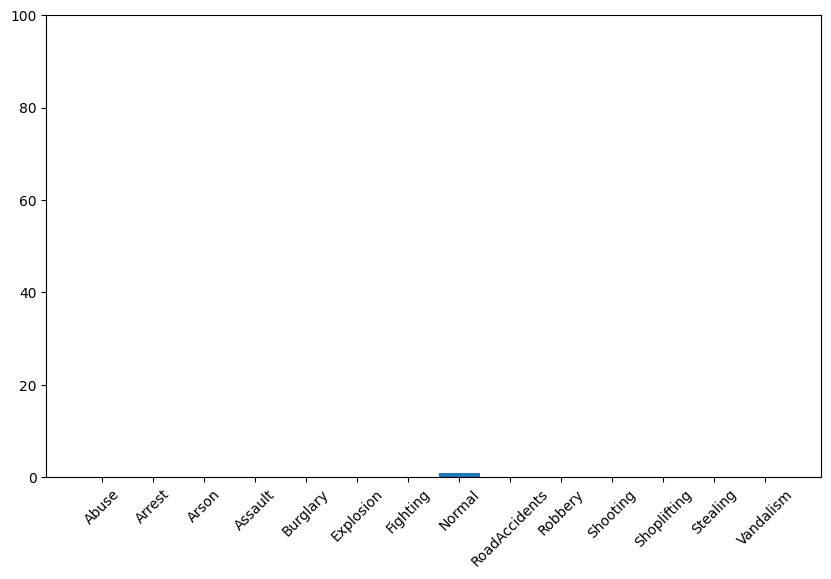

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the video
video = cv2.VideoCapture('/Khoa_hoc_dl_xu_ly_anh/Anomaly-Videos/Abuse/Abuse006_x264.mp4')

# Load the model (assuming a load_model function is available)
model = load_model('/Video_Anomaly_dectection_kaggle/Trained_model/my_model.h5')

# Placeholder for frames
frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break
    
    # Resize frame to 64x64 as required by the model
    frame_resized = cv2.resize(frame, (64, 64))
    
    frames.append(frame_resized)

# Convert frames to numpy array and predict using model's predict function or equivalent 
frames_np = np.array(frames)
predictions = model.predict(frames_np)

# Display predictions in a diagram (assuming matplotlib is appropriate)
labels = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
          'Fighting', "Normal", 'RoadAccidents', 'Robbery',
          'Shooting', 'Shoplifting','Stealing','Vandalism']

plt.figure(figsize=(10,6))
plt.bar(range(len(labels)), predictions.mean(axis=0), align='center')
plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylim(0.0, 1.0)
plt.show()
